In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
data=pd.read_csv('AirPassenger.csv')

In [3]:
data.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [4]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m')

In [7]:
data = pd.read_csv('AirPassenger.csv', parse_dates=['Month'], index_col='Month',date_parser=dateparse)
data.head()

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [8]:
ts=data['#Passengers']

In [9]:
ts

Month
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
1949-06-01    135
1949-07-01    148
1949-08-01    148
1949-09-01    136
1949-10-01    119
1949-11-01    104
1949-12-01    118
1950-01-01    115
1950-02-01    126
1950-03-01    141
1950-04-01    135
1950-05-01    125
1950-06-01    149
1950-07-01    170
1950-08-01    170
1950-09-01    158
1950-10-01    133
1950-11-01    114
1950-12-01    140
1951-01-01    145
1951-02-01    150
1951-03-01    178
1951-04-01    163
1951-05-01    172
1951-06-01    178
             ... 
1958-07-01    491
1958-08-01    505
1958-09-01    404
1958-10-01    359
1958-11-01    310
1958-12-01    337
1959-01-01    360
1959-02-01    342
1959-03-01    406
1959-04-01    396
1959-05-01    420
1959-06-01    472
1959-07-01    548
1959-08-01    559
1959-09-01    463
1959-10-01    407
1959-11-01    362
1959-12-01    405
1960-01-01    417
1960-02-01    391
1960-03-01    419
1960-04-01    461
1960-05-01    472
1960-06-01    535
1960

### checking stationarity of time series

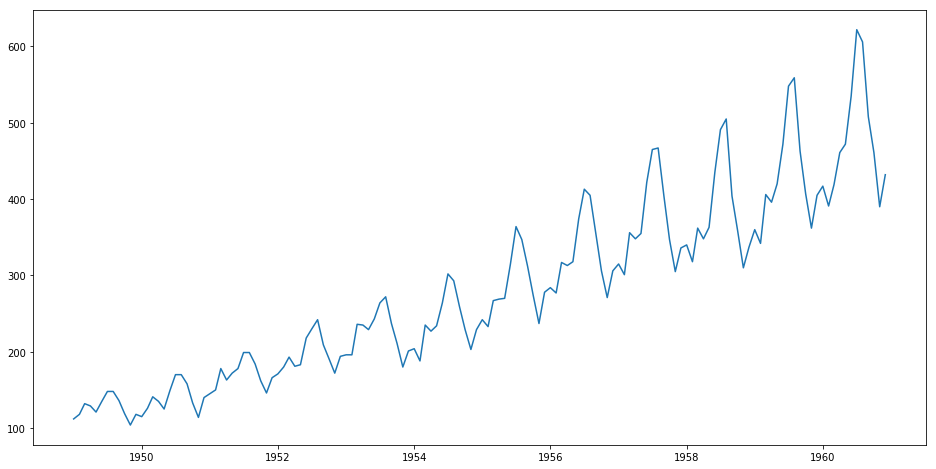

In [14]:

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
plt.figure(figsize=(16,8))
plt.plot(ts)

In [15]:
from statsmodels.tsa.stattools import adfuller


In [18]:
dftest = adfuller(ts, autolag='AIC')
dftest

(0.8153688792060423,
 0.9918802434376409,
 13,
 130,
 {'1%': -3.4816817173418295,
  '5%': -2.8840418343195267,
  '10%': -2.578770059171598},
 996.6929308390189)

In [38]:
def test_stationarity(timeseries):
    plt.figure(figsize=(14,7))
    rolmean=timeseries.rolling(12).mean()
    rolstd=timeseries.rolling(12).std()
     #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    

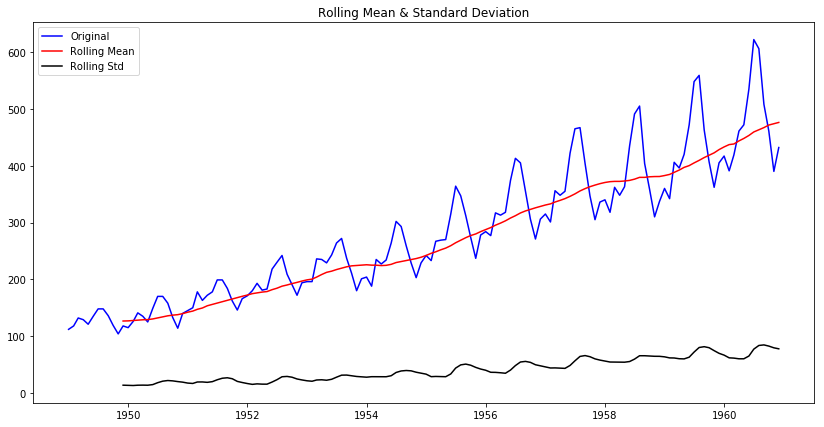

Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [39]:
test_stationarity(ts)

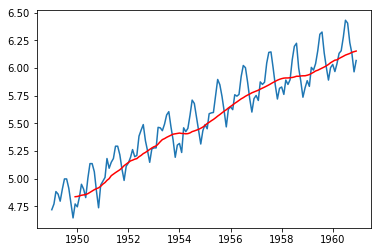

In [40]:
ts_log=np.log(ts)
moving_avr=ts_log.rolling(12).mean()
#moving_std=ts_log.rolling(12).std()
plt.plot(ts_log)
plt.plot(moving_avr,c='r')
#plt.plot(moving_std,c='black')

In [41]:
ts_log_moving_avr_diff=ts_log-moving_avr

In [42]:
ts_log_moving_avr_diff.dropna(inplace=True)

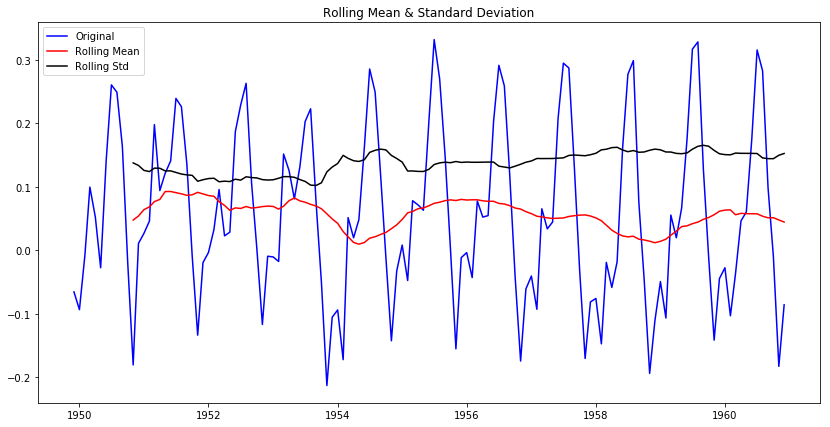

Results of Dickey-Fuller Test:
Test Statistic                  -3.162908
p-value                          0.022235
#Lags Used                      13.000000
Number of Observations Used    119.000000
Critical Value (1%)             -3.486535
Critical Value (5%)             -2.886151
Critical Value (10%)            -2.579896
dtype: float64


In [43]:
test_stationarity(ts_log_moving_avr_diff)

NotImplementedError: See issue #11704 https://github.com/pandas-dev/pandas/issues/11704

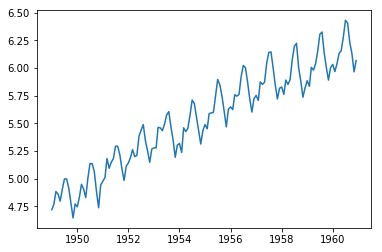

In [48]:
expwighted_avg = ts_log.ewm(span=1)
plt.plot(ts_log)
plt.plot(expwighted_avg, color='red')

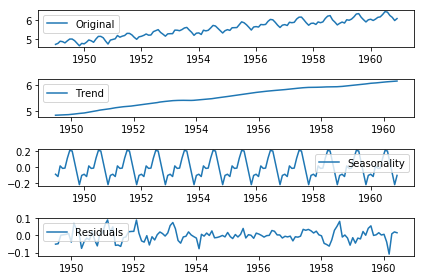

In [49]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

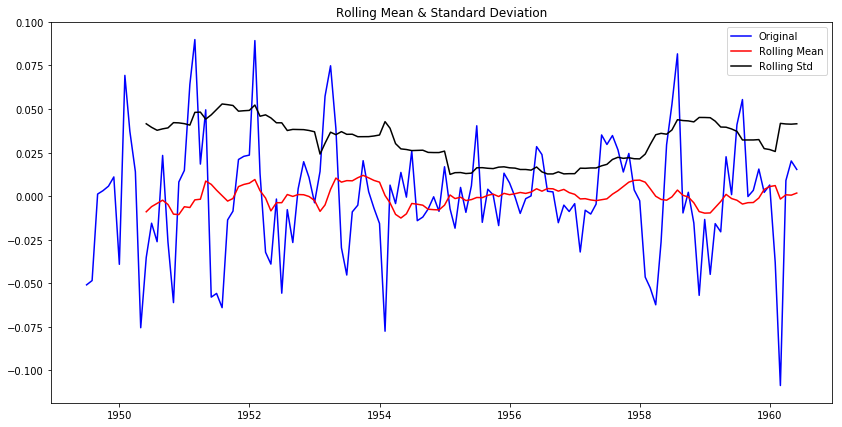

Results of Dickey-Fuller Test:
Test Statistic                -6.332387e+00
p-value                        2.885059e-08
#Lags Used                     9.000000e+00
Number of Observations Used    1.220000e+02
Critical Value (1%)           -3.485122e+00
Critical Value (5%)           -2.885538e+00
Critical Value (10%)          -2.579569e+00
dtype: float64


In [50]:
ts_log_decompose = residual
ts_log_decompose.dropna(inplace=True)
test_stationarity(ts_log_decompose)

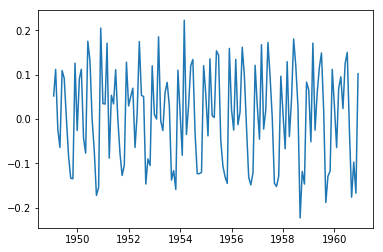

In [54]:
ts_log_diff = ts_log - ts_log.shift()
plt.plot(ts_log_diff)


## Forecasting a Time Series

### Ar model

In [55]:
from statsmodels.tsa.arima_model import ARIMA

C:\Users\Harishankar2\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Harishankar2\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:191: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  start=index[0], end=index[-1], freq=freq)


Text(0.5, 1.0, 'RSS: nan')

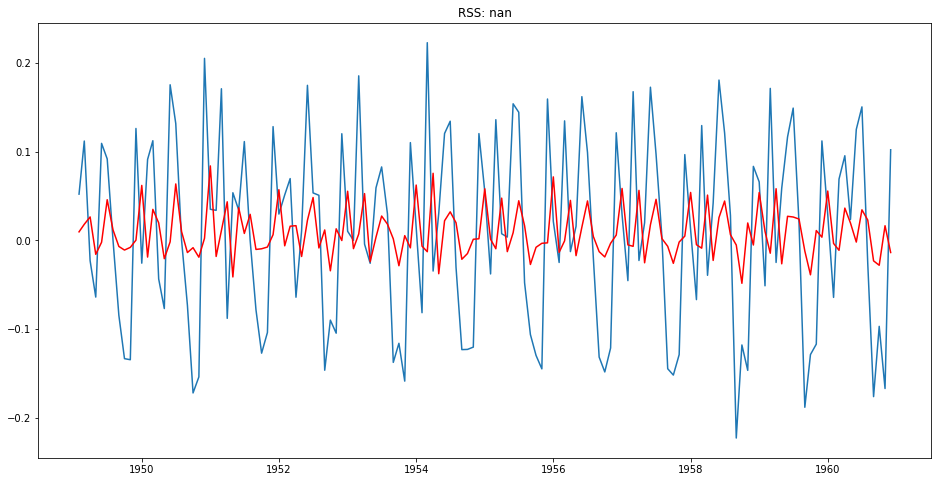

In [58]:
model = ARIMA(ts_log, order=(2, 1, 0))  
results_AR = model.fit(disp=-1)  
plt.figure(figsize=(16,8))
plt.plot(ts_log_diff)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-ts_log_diff)**2))

### ma model

Text(0.5, 1.0, 'RSS: nan')

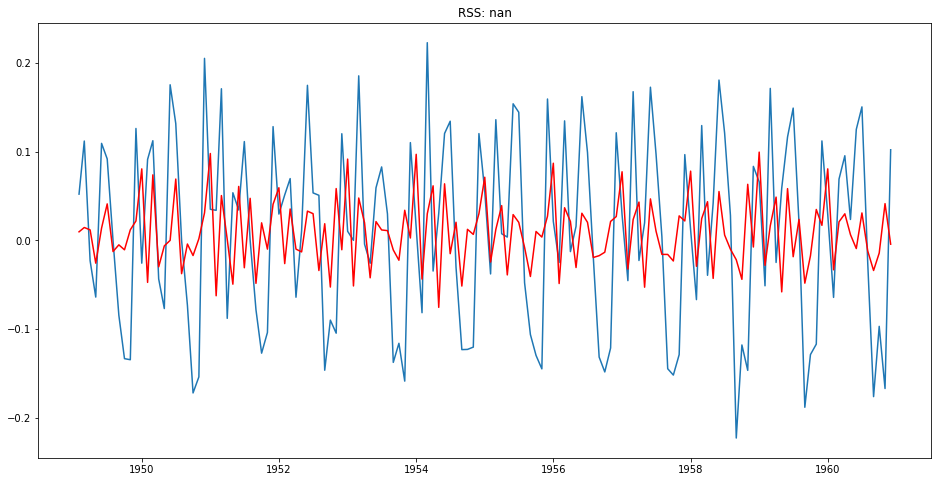

In [60]:
model = ARIMA(ts_log, order=(0, 1, 2))  
results_MA = model.fit(disp=-1)  
plt.figure(figsize=(16,8))
plt.plot(ts_log_diff)
plt.plot(results_MA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_MA.fittedvalues-ts_log_diff)**2))

### Combined model

Text(0.5, 1.0, 'RSS: nan')

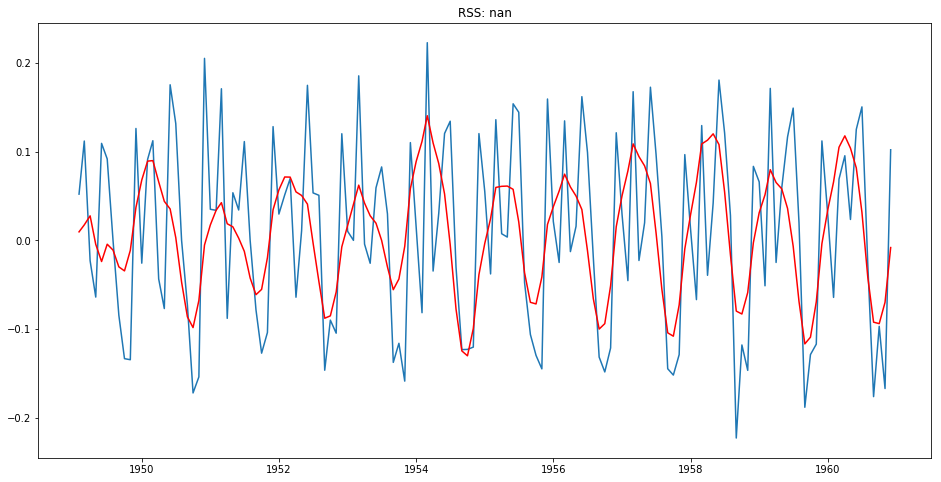

In [62]:
model = ARIMA(ts_log, order=(2, 1, 2))  
results_ARIMA = model.fit(disp=-1) 
plt.figure(figsize=(16,8))
plt.plot(ts_log_diff)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-ts_log_diff)**2))

In [64]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
predictions_ARIMA_diff.head()

Month
1949-02-01    0.009580
1949-03-01    0.017491
1949-04-01    0.027670
1949-05-01   -0.004521
1949-06-01   -0.023890
dtype: float64

In [65]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_diff_cumsum.head()

Month
1949-02-01    0.009580
1949-03-01    0.027071
1949-04-01    0.054742
1949-05-01    0.050221
1949-06-01    0.026331
dtype: float64

In [66]:
predictions_ARIMA_log = pd.Series(ts_log.ix[0], index=ts_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA_log.head()

C:\Users\Harishankar2\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.


Month
1949-01-01    4.718499
1949-02-01    4.728079
1949-03-01    4.745570
1949-04-01    4.773241
1949-05-01    4.768720
dtype: float64

Text(0.5, 1.0, 'RMSE: 51.6311')

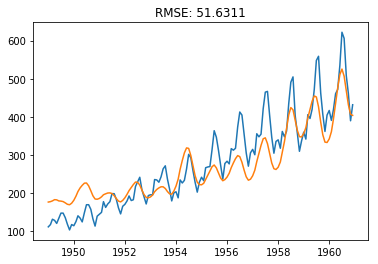

In [76]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(ts)
plt.plot(predictions_ARIMA+65)
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-ts+65)**2)/len(ts)))

In [79]:
data['predictions_ARIMA']=predictions_ARIMA
data

,#Passengers,predictions_ARIMA
Month,,
1949-01-01,112,112.000000
1949-02-01,118,113.078122
1949-03-01,132,115.073417
1949-04-01,129,118.301997
1949-05-01,121,117.768372
1949-06-01,135,114.988277
1949-07-01,148,114.489525
1949-08-01,148,113.239583
1949-09-01,136,109.900658
